# Assignment #2

Use single (hidden) layer NN to classify YaleB

1. Create LMDB
2. Create NN
3. Train & Test & Plot

In [66]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os
import lmdb
import caffe
from random import shuffle
from scipy.misc import imread

## Create LMDB

- Read data
- Create LMDB
- Test

In [67]:
n_people = 38
n_train_person = 35

X_train = []
y_train = []
X_test = []
y_test = []

def is_legal_filename(fn):
    return len(fn) >= 24 and fn.endswith('.pgm')

for p in range(n_people):
    people_id = p + 1 + (p >= 13) * 1
    dirname = 'CroppedYale/yaleB{:02}/'.format(people_id)
    filenames = [x for x in os.listdir(dirname) if is_legal_filename(x)]
    shuffle(filenames)
            
    for i, filename in enumerate(filenames[:n_train_person]):
        img = imread(dirname + filename, mode='F').ravel()
        X_train.append(img)
        y_train.append(p)
    
    for i, filename in enumerate(filenames[n_train_person:]):
        img = imread(dirname + filename, mode='F').ravel()
        X_test.append(img)
        y_test.append(p)
        
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

In [68]:
def write_lmdb(dirname, X, y):
    env = lmdb.open(dirname, map_size=(2**40))
#     indices = np.arange(X.shape[0])
    indices = np.random.permutation(X.shape[0])

    with env.begin(write=True) as txn:
        # txn is a Transaction object
        for i, x, y in zip(indices, X, y):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = 1
            datum.height = 192
            datum.width = 168
            datum.data = x.tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(y)
            txn.put('{:08}'.format(i), datum.SerializeToString())

!rm -rf ./train_lmdb
!rm -rf ./test_lmdb
write_lmdb('./train_lmdb', X_train, y_train)
write_lmdb('./test_lmdb', X_test, y_test)

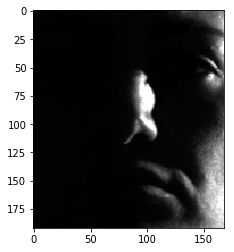

13


In [69]:
env = lmdb.open('./train_lmdb', readonly=True)
with env.begin() as txn:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(txn.get(b'00000000'))
    img = np.fromstring(datum.data, dtype=np.float32).reshape(192, 168)
    label = datum.label
    
    plt.imshow(img, cmap="gray")
    plt.show()
    print(label)

## Create NN

- Create `train_test_{}.prototxt`
- Create `solver_{}.prototxt`


In [70]:
train_test = '''\
name: "hw2"
layer {
  name: "YaleB"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "./train_lmdb"
    batch_size: 10
    backend: LMDB
  }
}
layer {
  name: "YaleB"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "./test_lmdb"
    batch_size: 10
    backend: LMDB
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "data"
  top: "fc1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: %d
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "fc2"
  type: "InnerProduct"
  bottom: "fc1"
  top: "fc2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 38
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "fc2"
  bottom: "label"
  top: "accuracy"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "fc2"
  bottom: "label"
  top: "loss"
}
'''

def create_nn(fc1_num):
    with open('./train_test_{}.prototxt'.format(fc1_num), 'w') as f:
        f.write(train_test % (fc1_num))

create_nn(1)
create_nn(10)
create_nn(50)

Drawing net to ./net_1.jpg
Drawing net to ./net_10.jpg
Drawing net to ./net_50.jpg


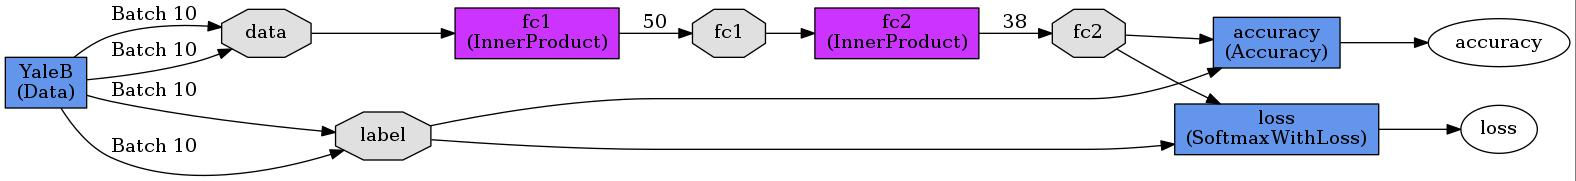

In [71]:
# Need graphviz, install it thru `apt install graphviz`
!draw_net.py --rankdir LR ./train_test_1.prototxt ./net_1.jpg
!draw_net.py --rankdir LR ./train_test_10.prototxt ./net_10.jpg
!draw_net.py --rankdir LR ./train_test_50.prototxt ./net_50.jpg
from IPython.display import Image
Image(filename='./net_50.jpg')

In [72]:
solver = '''\
net: "./train_test_%d.prototxt"
test_iter: 100
test_interval: 200
base_lr: 0.001
momentum: 0.9
weight_decay: 0.0005
lr_policy: "inv"
gamma: 0.0001
power: 0.75
display: 100
max_iter: 5000
snapshot: 5000
snapshot_prefix: "./snapshot"
solver_mode: CPU
'''

def create_solver(fc1_num):
    with open('./solver_{}.prototxt'.format(fc1_num), 'w') as f:
        f.write(solver % (fc1_num))
        
create_solver(1)
create_solver(10)
create_solver(50)

## Train and Plot

In [73]:
def train_and_plot(fc1_num):
    solver = caffe.SGDSolver('./solver_{}.prototxt'.format(fc1_num))
    niter = 5000
    test_interval = 200

    # losses will also be stored in the log
    train_loss = zeros(niter)
    test_acc = zeros(int(np.ceil(niter / test_interval)))

    # the main solver loop
    for it in range(niter):
        solver.step(1)  # SGD by Caffe

        # store the train loss
        train_loss[it] = solver.net.blobs['loss'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        solver.test_nets[0].forward(start='fc1')

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:
            correct = 0
            for test_it in range(100):
                solver.test_nets[0].forward()
                correct += sum(solver.test_nets[0].blobs['fc2'].data.argmax(1)
                               == solver.test_nets[0].blobs['label'].data)
            test_acc[it // test_interval] = correct / 1000.0
            print 'Iteration', it, correct / 1000.0
            
    _, ax1 = subplots()
    ax2 = ax1.twinx()
    ax1.plot(arange(niter), train_loss)
    ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('train loss')
    ax2.set_ylabel('test accuracy')
    ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

Iteration 0 0.026
Iteration 200 0.029
Iteration 400 0.034
Iteration 600 0.036
Iteration 800 0.032
Iteration 1000 0.046
Iteration 1200 0.029
Iteration 1400 0.042
Iteration 1600 0.024
Iteration 1800 0.049
Iteration 2000 0.05
Iteration 2200 0.044
Iteration 2400 0.054
Iteration 2600 0.051
Iteration 2800 0.045
Iteration 3000 0.054
Iteration 3200 0.044
Iteration 3400 0.052
Iteration 3600 0.056
Iteration 3800 0.044
Iteration 4000 0.055
Iteration 4200 0.04
Iteration 4400 0.045
Iteration 4600 0.036
Iteration 4800 0.047
CPU times: user 18 s, sys: 262 ms, total: 18.3 s
Wall time: 12.3 s


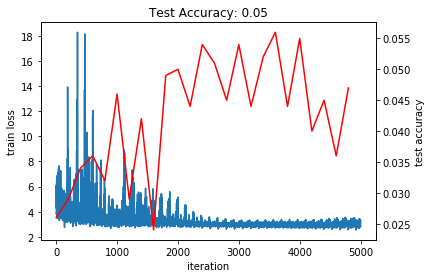

In [74]:
%%time
train_and_plot(1)

Iteration 0 0.022
Iteration 200 0.089
Iteration 400 0.113
Iteration 600 0.165
Iteration 800 0.199
Iteration 1000 0.246
Iteration 1200 0.192
Iteration 1400 0.265
Iteration 1600 0.245
Iteration 1800 0.274
Iteration 2000 0.263
Iteration 2200 0.29
Iteration 2400 0.314
Iteration 2600 0.292
Iteration 2800 0.331
Iteration 3000 0.316
Iteration 3200 0.354
Iteration 3400 0.33
Iteration 3600 0.366
Iteration 3800 0.319
Iteration 4000 0.356
Iteration 4200 0.354
Iteration 4400 0.35
Iteration 4600 0.373
Iteration 4800 0.359
CPU times: user 49.2 s, sys: 405 ms, total: 49.6 s
Wall time: 43.5 s


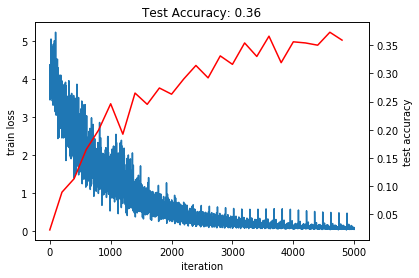

In [75]:
%%time
train_and_plot(10)

Iteration 0 0.031
Iteration 200 0.194
Iteration 400 0.219
Iteration 600 0.376
Iteration 800 0.453
Iteration 1000 0.432
Iteration 1200 0.461
Iteration 1400 0.485
Iteration 1600 0.509
Iteration 1800 0.487
Iteration 2000 0.541
Iteration 2200 0.516
Iteration 2400 0.558
Iteration 2600 0.549
Iteration 2800 0.567
Iteration 3000 0.558
Iteration 3200 0.563
Iteration 3400 0.565
Iteration 3600 0.564
Iteration 3800 0.555
Iteration 4000 0.58
Iteration 4200 0.558
Iteration 4400 0.563
Iteration 4600 0.557
Iteration 4800 0.56
CPU times: user 2min 14s, sys: 498 ms, total: 2min 14s
Wall time: 2min 8s


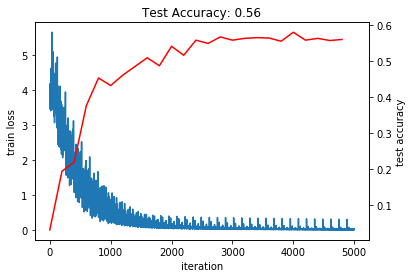

In [76]:
%%time
train_and_plot(50)